### Visualization Performance


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
import glob
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from utility.utility import *
from utility.techIndex import talib_index
from utility.model import dnn, lstm, conv1d, conv2d, transformer

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [2]:
# get last weight
newest = True

test_weight = {
    'transformer': '',
    'conv1d': '',
    'conv2d': '',
    'dnn': '',
    'lstm': ''
 }
# # test data
# stock = 'TWII_test.csv'

if newest:
    for model, folder in test_weight.items(): 
        # test_weight[model] = glob.glob(f'model/{model}/*/')[-1][:-1]
        test_weight[model] = glob.glob(f'model/{model}/*{config["STOCK"]["stock"]}*.index')[-1][:-6]

# window length
# slide = 30

df = read_data(config, 'test')
model_metric = {}
test_weight

data\TWII_test.csv


{'transformer': 'model/transformer\\20221007-001239_TWII_e30_s30',
 'conv1d': 'model/conv1d\\20221007-001605_TWII_e30_s30',
 'conv2d': 'model/conv2d\\20221007-001645_TWII_e30_s30',
 'dnn': 'model/dnn\\20221007-001135_TWII_e30_s30',
 'lstm': 'model/lstm\\20221007-001756_TWII_e30_s30'}

### Predict Price

In [3]:
%%time

X, y = label(df)
# X_dim = X.index
X_scaler, y_scaler = scaler(X, y, config, 'test')
# sns.set_palette("tab10")
metric = pd.DataFrame()
# metric = pd.DataFrame({'bench mark':y[int(config['MODEL']['slide']):]})
metric = pd.DataFrame(y_scaler[int(config['MODEL']['slide']):], index = y.index[int(config['MODEL']['slide']):], columns = ['bench mark'])
# metric['bench mark'] = y_scaler.reshape(1,-1)
mse_dict={}
for model_name, weight in test_weight.items(): 
    X_, y_ = training_window(X_scaler, y_scaler , config, model_name)
    model = load_model(X_.shape, model_name)
    model.load_weights(test_weight[model_name])
    y_pred = model.predict(X_)

    # if bool(config["STOCK"]["scale"]):
    #     y_pred = inverse_predict(y_pred, config)
    mse_dict[model_name] = mean_squared_error(y_scaler[int(config['MODEL']['slide']):], y_pred, squared=False)
    metric[model_name] = y_pred
    
display(metric)
mse_dict


scale

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 6)]      0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 30, 2)        120         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 30, 8)        0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 30, 8)       111920      ['concatenate[0][0]',

,bench mark,transformer,conv1d,conv2d,dnn,lstm
Date,,,,,,
2021-02-25,6.571780,1.216403,4.746149,4.295255,6.918843,5.731423
2021-02-26,6.829261,1.211875,4.830981,4.227346,6.958932,6.167294
2021-03-02,6.293798,1.219254,4.508147,4.170588,6.393054,5.164961
2021-03-03,6.286363,1.223172,4.548873,4.103128,6.039215,5.964374
2021-03-04,6.570921,1.221697,4.692926,4.049065,6.135551,5.629650
...,...,...,...,...,...,...
2021-12-24,8.434942,1.174749,6.113214,5.148554,7.029062,6.694318
2021-12-27,8.451037,1.170565,6.162275,5.171920,7.022173,6.575247
2021-12-28,8.544832,1.169088,6.286437,5.247296,7.180597,6.699705


CPU times: total: 9.14 s
Wall time: 9.64 s


{'transformer': 6.362302506534,
 'conv1d': 2.2253097414985508,
 'conv2d': 2.8173629494149472,
 'dnn': 0.8948511157213476,
 'lstm': 1.2533070396787223}

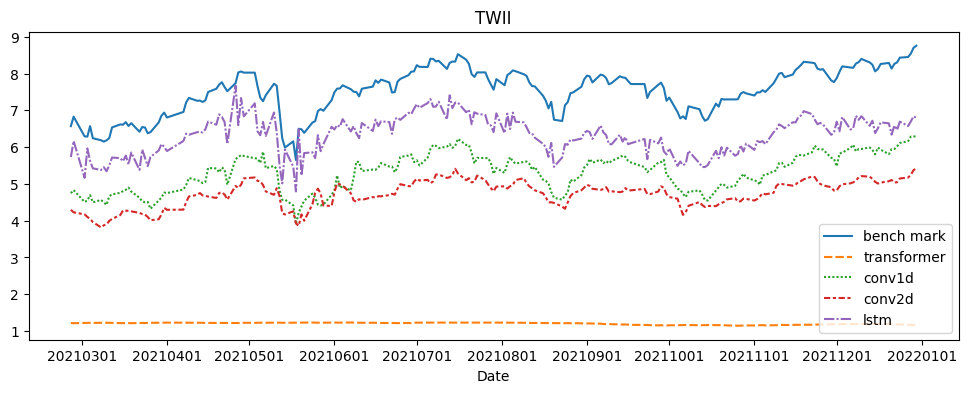

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
metric.index = pd.to_datetime(metric.index)
# sns.lineplot(data=metric, ax=ax)
sns.lineplot(data=metric.drop(columns='dnn',axis=1), ax=ax)
plt.title(f'{config["STOCK"]["stock"]}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
